In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt 
from scipy.stats import boxcox, ttest_ind
from sklearn.preprocessing import QuantileTransformer, PowerTransformer, MinMaxScaler, StandardScaler
import math


# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data-for-ml-course/sample_submission.csv
/kaggle/input/home-data-for-ml-course/sample_submission.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv.gz
/kaggle/input/home-data-for-ml-course/data_description.txt
/kaggle/input/home-data-for-ml-course/test.csv.gz
/kaggle/input/home-data-for-ml-course/train.csv
/kaggle/input/home-data-for-ml-course/test.csv
/kaggle/input/backup2/train.csv


In [2]:
pd.set_option("display.max_rows", None)
train_df = pd.read_csv("/kaggle/input/backup2/train.csv")
test_df = pd.read_csv("/kaggle/input/home-data-for-ml-course/test.csv")

In [3]:
print(train_df.isnull().sum().sum())
null_cols = train_df.columns[train_df.isnull().any()]
print(null_cols)

7829
Index(['LotFrontage', 'Alley', 'MasVnrType', 'MasVnrArea', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2',
       'Electrical', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC', 'Fence',
       'MiscFeature'],
      dtype='object')


In [4]:
print(train_df.isnull().sum().sort_values(ascending=False))

PoolQC           1453
MiscFeature      1406
Alley            1369
Fence            1179
MasVnrType        872
FireplaceQu       690
LotFrontage       259
GarageYrBlt        81
GarageCond         81
GarageType         81
GarageFinish       81
GarageQual         81
BsmtFinType2       38
BsmtExposure       38
BsmtQual           37
BsmtCond           37
BsmtFinType1       37
MasVnrArea          8
Electrical          1
Id                  0
Functional          0
Fireplaces          0
KitchenQual         0
KitchenAbvGr        0
BedroomAbvGr        0
HalfBath            0
FullBath            0
BsmtHalfBath        0
TotRmsAbvGrd        0
GarageCars          0
GrLivArea           0
GarageArea          0
PavedDrive          0
WoodDeckSF          0
OpenPorchSF         0
EnclosedPorch       0
3SsnPorch           0
ScreenPorch         0
PoolArea            0
MiscVal             0
MoSold              0
YrSold              0
SaleType            0
SaleCondition       0
BsmtFullBath        0
HeatingQC 

In [5]:
highNullCols = ["PoolQC", "MiscFeature", "Alley", "Fence", "FireplaceQu"]
train_df[highNullCols] = train_df[highNullCols].fillna("None")
train_df.isnull().sum().sum()

1732

# Handle Garage & Basement Columns Together

In [6]:
garage_cols = ["GarageType", "GarageCond", "GarageQual", "GarageFinish"]
train_df[garage_cols] = train_df[garage_cols].fillna("None")
train_df["GarageYrBlt"] = train_df["GarageYrBlt"].fillna(0)
train_df.isnull().sum().sum()

1327

# lotFrontage contains numerical values, and also has outliers, so putting the median in place of empty cells makes sense

In [7]:
train_df['LotFrontage'] = train_df['LotFrontage'].fillna(train_df['LotFrontage'].median())
train_df.isnull().sum().sum()

1068

In [8]:
train_df["MasVnrType"] = train_df["MasVnrType"].fillna("None")
train_df["MasVnrArea"] = train_df["MasVnrArea"].fillna(0)
train_df.isnull().sum().sum()

188

# Since "Electrical" column has only one value missing, we can just fill it with the most common value

In [9]:
print((train_df["Electrical"].isna() | (train_df["Electrical"] == "")).any())
train_df["Electrical"] = train_df["Electrical"].fillna(train_df["Electrical"].mode()[0])
train_df.isnull().sum().sum()

True


187

In [10]:
train_df["BsmtFinType2"] = train_df["BsmtFinType2"].fillna("None")
train_df["BsmtExposure"] = train_df["BsmtExposure"].fillna("None")
train_df["BsmtCond"] = train_df["BsmtCond"].fillna("None")
train_df["BsmtQual"] = train_df["BsmtQual"].fillna("None")
train_df["BsmtFinType1"] = train_df["BsmtFinType1"].fillna("None")
train_df.isnull().sum().sum()

0

# **one-hot encoding the nominal categorical features**

In [11]:
one_hot_cols = [
    "MSZoning", "Street", "Alley", "LotShape", "LandContour", "Utilities", "LotConfig",  
    "Neighborhood", "Condition1", "Condition2", "BldgType", "HouseStyle", "RoofStyle",  
    "RoofMatl", "Exterior1st", "Exterior2nd", "Foundation", "Heating", "CentralAir",  
    "GarageType", "SaleType", "SaleCondition", "MiscFeature", "Electrical", "MasVnrType"
]
# Find which categorical columns still need encoding
remaining_one_hot_cols = [col for col in one_hot_cols if col in train_df.columns]

# Apply One-Hot Encoding only on remaining columns
train_df = pd.get_dummies(train_df, columns=remaining_one_hot_cols, drop_first=True)

# **label encoding the ordinal categorical features**

In [12]:
ordinal_cols = {
    "ExterQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "ExterCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "BsmtQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "BsmtCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "BsmtExposure": {"Gd": 4, "Av": 3, "Mn": 2, "No": 1, "NA": 0},
    "BsmtFinType1": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0},
    "BsmtFinType2": {"GLQ": 6, "ALQ": 5, "BLQ": 4, "Rec": 3, "LwQ": 2, "Unf": 1, "NA": 0},
    "HeatingQC": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "KitchenQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1},
    "FireplaceQu": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "GarageFinish": {"Fin": 3, "RFn": 2, "Unf": 1, "NA": 0},
    "GarageQual": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "GarageCond": {"Ex": 5, "Gd": 4, "TA": 3, "Fa": 2, "Po": 1, "NA": 0},
    "PavedDrive": {"Y": 2, "P": 1, "N": 0},
    "Fence": {"GdPrv": 4, "MnPrv": 3, "GdWo": 2, "MnWw": 1, "NA": 0},
    "PoolQC": {"Ex": 4, "Gd": 3, "TA": 2, "Fa": 1, "NA": 0},
    "LandSlope": {"Glt": 2, "Mod": 1, "Sev": 0},
    "Functional": {"Sal": 0, "Sev": 1, "Maj2": 2, "Maj1": 3, "Mod": 4, "Min2": 5, "Min1": 6, "Typ": 7}
}

for col, mapping in ordinal_cols.items():
    train_df[col] = train_df[col].map(mapping)

In [13]:
print(train_df.dtypes.value_counts()) # used to check if the ENCODING step is complete or not

bool       150
int64       41
float64     15
Name: count, dtype: int64


# **avoiding encoded columns during normalisation, scaling**

In [14]:
# Step 1: Get label-encoded columns
label_encoded_cols = set(ordinal_cols.keys())  # These are directly encoded using ordinal encoding
one_hot_encoded_cols = set()
for orig_col in one_hot_cols:
    for col in train_df.columns:
        if col.startswith(f"{orig_col}_"):  # Check if col is a one-hot encoded version
            one_hot_encoded_cols.add(col)

# Step 3: Combine both
all_encoded_cols = label_encoded_cols.union(one_hot_encoded_cols)

print("Label Encoded Columns:", label_encoded_cols)
print("One-Hot Encoded Columns:", one_hot_encoded_cols)
print("Final Encoded Columns:", all_encoded_cols)

Label Encoded Columns: {'Fence', 'PoolQC', 'PavedDrive', 'GarageFinish', 'ExterCond', 'BsmtExposure', 'BsmtQual', 'BsmtFinType2', 'HeatingQC', 'BsmtFinType1', 'FireplaceQu', 'GarageQual', 'LandSlope', 'BsmtCond', 'Functional', 'ExterQual', 'GarageCond', 'KitchenQual'}
One-Hot Encoded Columns: {'Neighborhood_Edwards', 'Condition1_Feedr', 'RoofMatl_Metal', 'Exterior2nd_Plywood', 'SaleType_ConLI', 'LotShape_IR2', 'Condition1_RRNe', 'Neighborhood_Timber', 'Neighborhood_CollgCr', 'Exterior2nd_Wd Sdng', 'Heating_GasW', 'GarageType_Detchd', 'Neighborhood_Somerst', 'HouseStyle_SFoyer', 'Condition1_RRAe', 'BldgType_2fmCon', 'LotShape_Reg', 'SaleType_WD', 'RoofStyle_Hip', 'SaleCondition_Family', 'LandContour_HLS', 'LandContour_Lvl', 'RoofMatl_Roll', 'SaleCondition_AdjLand', 'SaleType_CWD', 'Neighborhood_StoneBr', 'Exterior1st_VinylSd', 'Neighborhood_ClearCr', 'Exterior1st_Stucco', 'MSZoning_RM', 'SaleType_New', 'Heating_Grav', 'Exterior2nd_ImStucc', 'Neighborhood_NAmes', 'Condition2_PosN', 'LotC

In [15]:
columns_list = train_df.columns
scalable_cols = list(set(columns_list) - all_encoded_cols)
print(scalable_cols)

['GrLivArea', 'SalePrice', 'EnclosedPorch', 'YearBuilt', 'LotFrontage', 'TotRmsAbvGrd', 'FullBath', 'BsmtHalfBath', 'MiscVal', '2ndFlrSF', 'HalfBath', 'BsmtFinSF2', 'YearRemodAdd', 'OverallCond', 'YrSold', 'BsmtUnfSF', 'MasVnrArea', 'OverallQual', 'WoodDeckSF', 'LotArea', 'Id', 'KitchenAbvGr', 'Fireplaces', 'OpenPorchSF', 'PoolArea', 'GarageYrBlt', 'BsmtFullBath', 'GarageArea', 'GarageCars', 'LowQualFinSF', 'MoSold', '3SsnPorch', 'ScreenPorch', 'BsmtFinSF1', 'MSSubClass', 'TotalBsmtSF', 'BedroomAbvGr', '1stFlrSF']


In [16]:
train_df[scalable_cols].skew() # if the skewness > 1, log transformation should be applied

GrLivArea         1.366560
SalePrice         1.882876
EnclosedPorch     3.089872
YearBuilt        -0.613461
LotFrontage       2.409147
TotRmsAbvGrd      0.676341
FullBath          0.036562
BsmtHalfBath      4.103403
MiscVal          24.476794
2ndFlrSF          0.813030
HalfBath          0.675897
BsmtFinSF2        4.255261
YearRemodAdd     -0.503562
OverallCond       0.693067
YrSold            0.096269
BsmtUnfSF         0.920268
MasVnrArea        2.677616
OverallQual       0.216944
WoodDeckSF        1.541376
LotArea          12.207688
Id                0.000000
KitchenAbvGr      4.488397
Fireplaces        0.649565
OpenPorchSF       2.364342
PoolArea         14.828374
GarageYrBlt      -3.869501
BsmtFullBath      0.596067
GarageArea        0.179981
GarageCars       -0.342549
LowQualFinSF      9.011341
MoSold            0.212053
3SsnPorch        10.304342
ScreenPorch       4.122214
BsmtFinSF1        1.685503
MSSubClass        1.407657
TotalBsmtSF       1.524255
BedroomAbvGr      0.211790
1

In [17]:
skewed_cols = train_df[scalable_cols].skew().abs()
highly_skewed = skewed_cols[skewed_cols > 1].index.tolist()
print(train_df[highly_skewed].skew().sort_values(ascending=False))

MiscVal          24.476794
PoolArea         14.828374
LotArea          12.207688
3SsnPorch        10.304342
LowQualFinSF      9.011341
KitchenAbvGr      4.488397
BsmtFinSF2        4.255261
ScreenPorch       4.122214
BsmtHalfBath      4.103403
EnclosedPorch     3.089872
MasVnrArea        2.677616
LotFrontage       2.409147
OpenPorchSF       2.364342
SalePrice         1.882876
BsmtFinSF1        1.685503
WoodDeckSF        1.541376
TotalBsmtSF       1.524255
MSSubClass        1.407657
1stFlrSF          1.376757
GrLivArea         1.366560
GarageYrBlt      -3.869501
dtype: float64


In [18]:
highly_skewed.remove("GarageYrBlt")

# **applying Power Transformation to Highly Skewed features**

In [19]:
pt = PowerTransformer(method="yeo-johnson")
train_df[highly_skewed] = pt.fit_transform(train_df[highly_skewed])
print(train_df[highly_skewed].skew().sort_values(ascending=False))

PoolArea         14.352680
3SsnPorch         7.613746
LowQualFinSF      7.299413
MiscVal           5.016528
BsmtHalfBath      3.859402
ScreenPorch       3.113266
BsmtFinSF2        2.425650
EnclosedPorch     2.047941
MasVnrArea        0.426258
TotalBsmtSF       0.232534
LotFrontage       0.167283
WoodDeckSF        0.132275
MSSubClass        0.069019
LotArea           0.026569
GrLivArea         0.000171
1stFlrSF         -0.001106
SalePrice        -0.008654
OpenPorchSF      -0.014772
BsmtFinSF1       -0.411401
KitchenAbvGr     -2.800950
dtype: float64


In [20]:
print(train_df['PoolArea'])

0       -0.069409
1       -0.069409
2       -0.069409
3       -0.069409
4       -0.069409
5       -0.069409
6       -0.069409
7       -0.069409
8       -0.069409
9       -0.069409
10      -0.069409
11      -0.069409
12      -0.069409
13      -0.069409
14      -0.069409
15      -0.069409
16      -0.069409
17      -0.069409
18      -0.069409
19      -0.069409
20      -0.069409
21      -0.069409
22      -0.069409
23      -0.069409
24      -0.069409
25      -0.069409
26      -0.069409
27      -0.069409
28      -0.069409
29      -0.069409
30      -0.069409
31      -0.069409
32      -0.069409
33      -0.069409
34      -0.069409
35      -0.069409
36      -0.069409
37      -0.069409
38      -0.069409
39      -0.069409
40      -0.069409
41      -0.069409
42      -0.069409
43      -0.069409
44      -0.069409
45      -0.069409
46      -0.069409
47      -0.069409
48      -0.069409
49      -0.069409
50      -0.069409
51      -0.069409
52      -0.069409
53      -0.069409
54      -0.069409
55      -0

# transforming: PoolArea -> Hash_Pool (binary feature)

In [21]:
train_df['Has_Pool'] = (train_df['PoolArea'] > 0).astype(int)  

# Drop the original PoolArea column
train_df.drop(columns=['PoolArea'], inplace=True)

# Verify changes
print(train_df[['Has_Pool']].value_counts())

Has_Pool
0           1453
1              7
Name: count, dtype: int64


In [22]:
train_df['Has_Pool'].skew()

14.352680446365202

In [23]:
highly_skewed.remove('PoolArea')
print(train_df[highly_skewed].skew().sort_values(ascending=False))

3SsnPorch        7.613746
LowQualFinSF     7.299413
MiscVal          5.016528
BsmtHalfBath     3.859402
ScreenPorch      3.113266
BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: 3SsnPorch -> dropped

In [24]:
train_df.drop(columns=["3SsnPorch"], inplace=True)

In [25]:
highly_skewed.remove('3SsnPorch')
print(train_df[highly_skewed].skew().sort_values(ascending=False))

LowQualFinSF     7.299413
MiscVal          5.016528
BsmtHalfBath     3.859402
ScreenPorch      3.113266
BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: LowQualFinSF -> LowQualFinSF_binary

In [26]:
train_df[["LowQualFinSF", "SalePrice"]].corr()

,LowQualFinSF,SalePrice
LowQualFinSF,1.000000,-0.057153
SalePrice,-0.057153,1.000000


In [27]:
train_df['LowQualFinSF_binary'] = (train_df['LowQualFinSF'] > 0).astype(int)  

# Drop the original LowQualFinSF column
train_df.drop(columns=['LowQualFinSF'], inplace=True)

# Verify changes
print(train_df[['LowQualFinSF_binary']].value_counts())

LowQualFinSF_binary
0                      1434
1                        26
Name: count, dtype: int64


In [28]:
train_df.groupby('LowQualFinSF_binary')['SalePrice'].mean()

LowQualFinSF_binary
0    0.007696
1   -0.424451
Name: SalePrice, dtype: float64

In [29]:
group1 = train_df[train_df["LowQualFinSF_binary"] == 0]["SalePrice"]
group2 = train_df[train_df["LowQualFinSF_binary"] == 1]["SalePrice"]

t_stat, p_value = ttest_ind(group1, group2, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_value}")

T-statistic: 2.3000453528563702, P-value: 0.02971871276731583


In [30]:
highly_skewed.remove('LowQualFinSF')

In [31]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

MiscVal          5.016528
BsmtHalfBath     3.859402
ScreenPorch      3.113266
BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: MiscVal -> MiscVal_binary

In [32]:
train_df['MiscVal']

0      -0.192177
1      -0.192177
2      -0.192177
3      -0.192177
4      -0.192177
5       5.203549
6      -0.192177
7       5.203549
8      -0.192177
9      -0.192177
10     -0.192177
11     -0.192177
12     -0.192177
13     -0.192177
14     -0.192177
15     -0.192177
16      5.203549
17      5.203549
18     -0.192177
19     -0.192177
20     -0.192177
21     -0.192177
22     -0.192177
23     -0.192177
24     -0.192177
25     -0.192177
26     -0.192177
27     -0.192177
28     -0.192177
29     -0.192177
30     -0.192177
31     -0.192177
32     -0.192177
33     -0.192177
34     -0.192177
35     -0.192177
36     -0.192177
37     -0.192177
38     -0.192177
39     -0.192177
40     -0.192177
41     -0.192177
42     -0.192177
43     -0.192177
44     -0.192177
45     -0.192177
46     -0.192177
47     -0.192177
48     -0.192177
49     -0.192177
50     -0.192177
51      5.203549
52     -0.192177
53     -0.192177
54     -0.192177
55     -0.192177
56     -0.192177
57     -0.192177
58     -0.1921

In [33]:
correlation_transformed = train_df['MiscVal'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['MiscVal', 'SalePrice']].corr())
train_df.groupby("MiscVal")["SalePrice"].mean()

Pearson correlation (transformed): -0.073563087982207
            MiscVal  SalePrice
MiscVal    1.000000  -0.073563
SalePrice -0.073563   1.000000


MiscVal
-0.192177    0.014137
 5.203549   -2.837591
 5.203549    0.468440
 5.203549   -0.354279
 5.203549   -1.003190
 5.203549   -0.272092
 5.203549   -0.078692
 5.203549   -1.845220
 5.203549   -0.822519
 5.203549   -1.626287
 5.203549    0.023190
 5.203549   -1.043784
 5.203549    1.072865
 5.203549   -0.785589
 5.203549   -0.087882
 5.203549   -0.041203
 5.203549    0.366180
 5.203549    1.170202
 5.203549   -2.886403
 5.203549    0.057984
Name: SalePrice, dtype: float64

In [34]:
# Create binary column
train_df['MiscVal_binary'] = (train_df['MiscVal'] > 0).astype(int)

# Perform t-test
group_0 = train_df[train_df['MiscVal_binary'] == 0]['SalePrice']
group_1 = train_df[train_df['MiscVal_binary'] == 1]['SalePrice']

t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

T-statistic: 2.936874810706555, P-value: 0.004827673116479876


In [35]:
train_df.drop(columns=['MiscVal'], inplace=True)

In [36]:
if "MiscVal" in train_df.columns:
    print("Column exists!")
else:
    print("Column does not exist!")

Column does not exist!


In [37]:
highly_skewed.remove('MiscVal')

In [38]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

BsmtHalfBath     3.859402
ScreenPorch      3.113266
BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: BsmtHalfBath -> dropped

In [39]:
train_df['BsmtHalfBath']

0      -0.243940
1       4.099375
2      -0.243940
3      -0.243940
4      -0.243940
5      -0.243940
6      -0.243940
7      -0.243940
8      -0.243940
9      -0.243940
10     -0.243940
11     -0.243940
12     -0.243940
13     -0.243940
14     -0.243940
15     -0.243940
16     -0.243940
17     -0.243940
18     -0.243940
19     -0.243940
20     -0.243940
21     -0.243940
22     -0.243940
23     -0.243940
24     -0.243940
25     -0.243940
26      4.099375
27     -0.243940
28     -0.243940
29     -0.243940
30     -0.243940
31     -0.243940
32     -0.243940
33      4.099375
34     -0.243940
35     -0.243940
36     -0.243940
37      4.099375
38     -0.243940
39     -0.243940
40     -0.243940
41      4.099375
42     -0.243940
43     -0.243940
44     -0.243940
45     -0.243940
46     -0.243940
47     -0.243940
48     -0.243940
49     -0.243940
50      4.099375
51     -0.243940
52     -0.243940
53     -0.243940
54     -0.243940
55     -0.243940
56     -0.243940
57     -0.243940
58     -0.2439

In [40]:
correlation_transformed = train_df['BsmtHalfBath'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['BsmtHalfBath', 'SalePrice']].corr())
train_df.groupby("BsmtHalfBath")["SalePrice"].mean()

Pearson correlation (transformed): -0.0029851860735952166
              BsmtHalfBath  SalePrice
BsmtHalfBath      1.000000  -0.002985
SalePrice        -0.002985   1.000000


BsmtHalfBath
-0.243940    0.000728
 4.099375   -0.009191
 4.099375   -0.134110
Name: SalePrice, dtype: float64

In [41]:
train_df["BsmtHalfBath_binary"] = (train_df["BsmtHalfBath"] > 0).astype(int)

group_0 = train_df[train_df["BsmtHalfBath_binary"] == 0]["SalePrice"]
group_1 = train_df[train_df["BsmtHalfBath_binary"] == 1]["SalePrice"]

t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

T-statistic: 0.14516569313519817, P-value: 0.8848768029291472


In [42]:
train_df.drop(columns=["BsmtHalfBath"], inplace=True)

In [43]:
train_df.drop(columns=["BsmtHalfBath_binary"], inplace=True)

In [44]:
if "BsmtHalfBath_binary" in train_df.columns:
    print("Column exists!")
else:
    print("Column does not exist!")

Column does not exist!


In [45]:
highly_skewed.remove('BsmtHalfBath')

In [46]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

ScreenPorch      3.113266
BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: ScreenPorch -> ScreenPorch_binary

In [47]:
train_df['ScreenPorch']

0      -0.293785
1      -0.293785
2      -0.293785
3      -0.293785
4      -0.293785
5      -0.293785
6      -0.293785
7      -0.293785
8      -0.293785
9      -0.293785
10     -0.293785
11     -0.293785
12      3.403863
13     -0.293785
14     -0.293785
15     -0.293785
16     -0.293785
17     -0.293785
18     -0.293785
19     -0.293785
20     -0.293785
21     -0.293785
22     -0.293785
23     -0.293785
24     -0.293785
25     -0.293785
26     -0.293785
27     -0.293785
28     -0.293785
29     -0.293785
30     -0.293785
31     -0.293785
32     -0.293785
33     -0.293785
34     -0.293785
35     -0.293785
36     -0.293785
37     -0.293785
38     -0.293785
39     -0.293785
40     -0.293785
41     -0.293785
42     -0.293785
43     -0.293785
44     -0.293785
45     -0.293785
46      3.403866
47     -0.293785
48     -0.293785
49     -0.293785
50     -0.293785
51     -0.293785
52     -0.293785
53     -0.293785
54     -0.293785
55     -0.293785
56     -0.293785
57     -0.293785
58     -0.2937

In [48]:
correlation_transformed = train_df['ScreenPorch'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['ScreenPorch', 'SalePrice']].corr())
train_df.groupby("ScreenPorch")["SalePrice"].mean()

train_df["ScreenPorch_binary"] = (train_df["ScreenPorch"] > 0).astype(int)

group_0 = train_df[train_df["ScreenPorch_binary"] == 0]["SalePrice"]
group_1 = train_df[train_df["ScreenPorch_binary"] == 1]["SalePrice"]

t_stat, p_val = ttest_ind(group_0, group_1, equal_var=False)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

Pearson correlation (transformed): 0.10010666814729147
             ScreenPorch  SalePrice
ScreenPorch     1.000000   0.100107
SalePrice       0.100107   1.000000
T-statistic: -4.370169517092682, P-value: 2.3682528259345204e-05


In [49]:
train_df.drop(columns=["ScreenPorch"], inplace=True)
highly_skewed.remove('ScreenPorch')

In [50]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

BsmtFinSF2       2.425650
EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: BsmtFinSF2 -> dropped

In [51]:
train_df['BsmtFinSF2']

0      -0.359384
1      -0.359384
2      -0.359384
3      -0.359384
4      -0.359384
5      -0.359384
6      -0.359384
7       2.768436
8      -0.359384
9      -0.359384
10     -0.359384
11     -0.359384
12     -0.359384
13     -0.359384
14     -0.359384
15     -0.359384
16     -0.359384
17     -0.359384
18     -0.359384
19     -0.359384
20     -0.359384
21     -0.359384
22     -0.359384
23     -0.359384
24      2.783655
25     -0.359384
26      2.783557
27     -0.359384
28     -0.359384
29     -0.359384
30     -0.359384
31     -0.359384
32     -0.359384
33     -0.359384
34     -0.359384
35     -0.359384
36     -0.359384
37     -0.359384
38     -0.359384
39     -0.359384
40     -0.359384
41     -0.359384
42      2.780686
43      2.783561
44      2.783572
45     -0.359384
46     -0.359384
47     -0.359384
48     -0.359384
49     -0.359384
50     -0.359384
51     -0.359384
52      2.783670
53     -0.359384
54     -0.359384
55     -0.359384
56     -0.359384
57     -0.359384
58     -0.3593

In [52]:
correlation_transformed = train_df['BsmtFinSF2'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['BsmtFinSF2', 'SalePrice']].corr())
train_df.groupby("BsmtFinSF2")["SalePrice"].mean()

train_df["BsmtFinSF2_binary"] = (train_df["BsmtFinSF2"] > 0).astype(int)

t_stat, p_val = ttest_ind(
    train_df.loc[train_df['BsmtFinSF2_binary']==1, 'SalePrice'],
    train_df.loc[train_df['BsmtFinSF2_binary']==0, 'SalePrice'],
    equal_var=False
)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

Pearson correlation (transformed): -0.03271271682824369
            BsmtFinSF2  SalePrice
BsmtFinSF2    1.000000  -0.032713
SalePrice    -0.032713   1.000000
T-statistic: -1.518342947299912, P-value: 0.13022502532922314


In [53]:
train_df.drop(columns=["BsmtFinSF2"], inplace=True)
train_df.drop(columns=["BsmtFinSF2_binary"], inplace=True)
highly_skewed.remove('BsmtFinSF2')

In [54]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

EnclosedPorch    2.047941
MasVnrArea       0.426258
TotalBsmtSF      0.232534
LotFrontage      0.167283
WoodDeckSF       0.132275
MSSubClass       0.069019
LotArea          0.026569
GrLivArea        0.000171
1stFlrSF        -0.001106
SalePrice       -0.008654
OpenPorchSF     -0.014772
BsmtFinSF1      -0.411401
KitchenAbvGr    -2.800950
dtype: float64


# transformation: EnclosedPorch -> EnclosedPorch_binary

In [55]:
train_df['EnclosedPorch']

0      -0.407595
1      -0.407595
2      -0.407595
3       2.456640
4      -0.407595
5      -0.407595
6      -0.407595
7       2.456358
8       2.456151
9      -0.407595
10     -0.407595
11     -0.407595
12     -0.407595
13     -0.407595
14      2.455794
15     -0.407595
16     -0.407595
17     -0.407595
18     -0.407595
19     -0.407595
20     -0.407595
21      2.456151
22     -0.407595
23     -0.407595
24     -0.407595
25     -0.407595
26     -0.407595
27     -0.407595
28     -0.407595
29      2.452668
30      2.455733
31     -0.407595
32     -0.407595
33     -0.407595
34     -0.407595
35     -0.407595
36     -0.407595
37     -0.407595
38     -0.407595
39     -0.407595
40     -0.407595
41     -0.407595
42     -0.407595
43     -0.407595
44     -0.407595
45     -0.407595
46     -0.407595
47     -0.407595
48      2.453663
49     -0.407595
50     -0.407595
51     -0.407595
52     -0.407595
53     -0.407595
54     -0.407595
55     -0.407595
56     -0.407595
57     -0.407595
58      2.4412

In [56]:
correlation_transformed = train_df['EnclosedPorch'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['EnclosedPorch', 'SalePrice']].corr())
train_df.groupby("EnclosedPorch")["SalePrice"].mean()

train_df["EnclosedPorch_binary"] = (train_df["EnclosedPorch"] > 0).astype(int)

t_stat, p_val = ttest_ind(
    train_df.loc[train_df['EnclosedPorch_binary']==1, 'SalePrice'],
    train_df.loc[train_df['EnclosedPorch_binary']==0, 'SalePrice'],
    equal_var=False
)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

Pearson correlation (transformed): -0.21798067326282436
               EnclosedPorch  SalePrice
EnclosedPorch       1.000000  -0.217981
SalePrice          -0.217981   1.000000
T-statistic: -8.603928655620336, P-value: 5.458691279462662e-16


In [57]:
train_df.drop(columns=["EnclosedPorch"], inplace=True)
highly_skewed.remove('EnclosedPorch')

In [58]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

MasVnrArea      0.426258
TotalBsmtSF     0.232534
LotFrontage     0.167283
WoodDeckSF      0.132275
MSSubClass      0.069019
LotArea         0.026569
GrLivArea       0.000171
1stFlrSF       -0.001106
SalePrice      -0.008654
OpenPorchSF    -0.014772
BsmtFinSF1     -0.411401
KitchenAbvGr   -2.800950
dtype: float64


# transformation: KitchenAbvGr -> KitchenAbvGr_binary

In [59]:
train_df['KitchenAbvGr']

0       -0.172658
1       -0.172658
2       -0.172658
3       -0.172658
4       -0.172658
5       -0.172658
6       -0.172658
7       -0.172658
8        3.842316
9        3.842316
10      -0.172658
11      -0.172658
12      -0.172658
13      -0.172658
14      -0.172658
15      -0.172658
16      -0.172658
17       3.842316
18      -0.172658
19      -0.172658
20      -0.172658
21      -0.172658
22      -0.172658
23      -0.172658
24      -0.172658
25      -0.172658
26      -0.172658
27      -0.172658
28      -0.172658
29      -0.172658
30      -0.172658
31      -0.172658
32      -0.172658
33      -0.172658
34      -0.172658
35      -0.172658
36      -0.172658
37      -0.172658
38      -0.172658
39       3.842316
40      -0.172658
41      -0.172658
42      -0.172658
43      -0.172658
44      -0.172658
45      -0.172658
46      -0.172658
47      -0.172658
48       5.322611
49      -0.172658
50      -0.172658
51      -0.172658
52      -0.172658
53      -0.172658
54      -0.172658
55      -0

In [60]:
correlation_transformed = train_df['KitchenAbvGr'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['KitchenAbvGr', 'SalePrice']].corr())
train_df.groupby("KitchenAbvGr")["SalePrice"].mean()

# Simple binary feature: standard (0-1) vs multiple (2+) kitchens
train_df["KitchenAbvGr_binary"] = (train_df["KitchenAbvGr"] > 1).astype(int)

t_stat, p_val = ttest_ind(
    train_df.loc[train_df['KitchenAbvGr_binary']==1, 'SalePrice'],
    train_df.loc[train_df['KitchenAbvGr_binary']==0, 'SalePrice'],
    equal_var=False
)
print(f"T-statistic: {t_stat}, P-value: {p_val}")

Pearson correlation (transformed): -0.11935620119393482
              KitchenAbvGr  SalePrice
KitchenAbvGr      1.000000  -0.119356
SalePrice        -0.119356   1.000000
T-statistic: -8.774207457732542, P-value: 1.8726762772655114e-13


In [61]:
mean_diff = np.mean(group_1) - np.mean(group_0)
pooled_std = np.sqrt((np.var(group_0, ddof=1) + np.var(group_1, ddof=1)) / 2)
cohens_d = mean_diff / pooled_std

print(f"Cohen's d: {cohens_d}")

Cohen's d: 0.39489364705672336


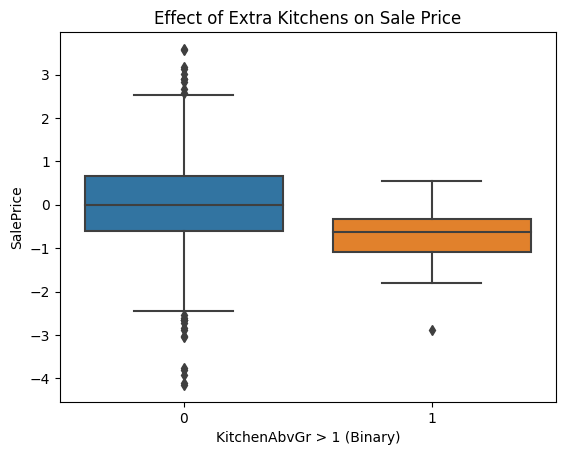

In [62]:
sns.boxplot(x=train_df["KitchenAbvGr_binary"], y=train_df["SalePrice"])
plt.xlabel("KitchenAbvGr > 1 (Binary)")
plt.ylabel("SalePrice")
plt.title("Effect of Extra Kitchens on Sale Price")
plt.show()

In [63]:
train_df.drop(columns=["KitchenAbvGr"], inplace=True)
highly_skewed.remove('KitchenAbvGr')

In [64]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

MasVnrArea     0.426258
TotalBsmtSF    0.232534
LotFrontage    0.167283
WoodDeckSF     0.132275
MSSubClass     0.069019
LotArea        0.026569
GrLivArea      0.000171
1stFlrSF      -0.001106
SalePrice     -0.008654
OpenPorchSF   -0.014772
BsmtFinSF1    -0.411401
dtype: float64


# transformation: GarageYrBlt -> GarageYrBlt_Binned

In [65]:
train_df['GarageYrBlt']

0       2003.0
1       1976.0
2       2001.0
3       1998.0
4       2000.0
5       1993.0
6       2004.0
7       1973.0
8       1931.0
9       1939.0
10      1965.0
11      2005.0
12      1962.0
13      2006.0
14      1960.0
15      1991.0
16      1970.0
17      1967.0
18      2004.0
19      1958.0
20      2005.0
21      1930.0
22      2002.0
23      1976.0
24      1968.0
25      2007.0
26      2005.0
27      2008.0
28      1957.0
29      1920.0
30      1920.0
31      1966.0
32      2007.0
33      1959.0
34      2005.0
35      2004.0
36      1995.0
37      1954.0
38      1953.0
39         0.0
40      1965.0
41      1959.0
42      1983.0
43      1977.0
44      1959.0
45      2005.0
46      2003.0
47      2006.0
48         0.0
49      1966.0
50      1997.0
51      1985.0
52      1963.0
53      1981.0
54      1962.0
55      1964.0
56      1999.0
57      2004.0
58      2006.0
59      1973.0
60      2006.0
61      1935.0
62      2006.0
63      1990.0
64      1998.0
65      2004.0
66      19

In [66]:
correlation_transformed = train_df['GarageYrBlt'].corr(train_df['SalePrice'])
print(f"Pearson correlation (transformed): {correlation_transformed}")
print(train_df[['GarageYrBlt', 'SalePrice']].corr())
train_df.groupby("GarageYrBlt")["SalePrice"].mean()

Pearson correlation (transformed): 0.3550716251788237
             GarageYrBlt  SalePrice
GarageYrBlt     1.000000   0.355072
SalePrice       0.355072   1.000000


GarageYrBlt
0.0      -1.357967
1900.0   -0.538759
1906.0   -0.517908
1908.0    0.915952
1910.0   -0.731821
1914.0   -0.243437
1915.0   -0.636781
1916.0   -0.702601
1918.0    0.885184
1920.0   -1.335065
1921.0   -0.599834
1922.0   -0.626904
1923.0    0.005571
1924.0   -0.908888
1925.0   -0.409699
1926.0   -0.626147
1927.0   -0.928935
1928.0   -0.782540
1929.0   -0.327148
1930.0   -0.734022
1931.0   -0.308998
1932.0    0.477951
1933.0   -0.471194
1934.0    0.728829
1935.0   -0.562038
1936.0   -0.524797
1937.0   -0.782614
1938.0   -1.690863
1939.0   -0.181060
1940.0   -0.516033
1941.0   -0.875244
1942.0   -0.069103
1945.0   -0.920904
1946.0   -0.861724
1947.0   -0.684802
1948.0   -0.559084
1949.0   -0.765853
1950.0   -0.549572
1951.0   -0.461750
1952.0   -1.435979
1953.0   -0.441465
1954.0   -0.536232
1955.0   -0.456934
1956.0   -0.788784
1957.0   -0.471861
1958.0   -0.655126
1959.0   -0.158024
1960.0   -0.164891
1961.0   -0.508411
1962.0   -0.467436
1963.0   -0.461660
1964.0   -0.211668


In [67]:
bins = [-1, 1, 1940, 1970, 1990, 2000, float('inf')]  # Changed 0 → -1
labels = ['NoGarage', 'Pre1940', '1940-1970', '1970-1990', '1990-2000', 'Post2000']

train_df['GarageYrBlt_Binned'] = pd.cut(train_df['GarageYrBlt'], bins=bins, labels=labels)

In [68]:
if "GarageYrBlt_Binned" in train_df.columns:
    print("it is there")
else:
    print("it is not there")

it is there


In [69]:
print(train_df['GarageYrBlt_Binned'].value_counts(dropna=False))

GarageYrBlt_Binned
1940-1970    397
Post2000     375
1970-1990    277
1990-2000    207
Pre1940      123
NoGarage      81
Name: count, dtype: int64


In [70]:
print(train_df[train_df['GarageYrBlt_Binned'].isna()]['GarageYrBlt'].unique())

[]


In [71]:
print(train_df[highly_skewed].skew().sort_values(ascending=False))

MasVnrArea     0.426258
TotalBsmtSF    0.232534
LotFrontage    0.167283
WoodDeckSF     0.132275
MSSubClass     0.069019
LotArea        0.026569
GrLivArea      0.000171
1stFlrSF      -0.001106
SalePrice     -0.008654
OpenPorchSF   -0.014772
BsmtFinSF1    -0.411401
dtype: float64


# **Normalising the features**

In [72]:
# 1. Detect binary features (only 0s and 1s)
binary_features = [col for col in train_df.columns if train_df[col].nunique() == 2]

# 2. Detect binned categorical features (few unique values, but >2)
# Assuming binned features have fewer than, say, 10 unique values
binned_features = [col for col in train_df.columns if 2 < train_df[col].nunique() <= 6]

# 3. Detect continuous features (more than 10 unique values)
continuous_features = [col for col in train_df.columns if train_df[col].nunique() > 10]

print("Binary Features:", binary_features)
print("Binned Features:", binned_features)
print("Continuous Features:", continuous_features)

Binary Features: ['LandSlope', 'MSZoning_FV', 'MSZoning_RH', 'MSZoning_RL', 'MSZoning_RM', 'Street_Pave', 'Alley_None', 'Alley_Pave', 'LotShape_IR2', 'LotShape_IR3', 'LotShape_Reg', 'LandContour_HLS', 'LandContour_Low', 'LandContour_Lvl', 'Utilities_NoSeWa', 'LotConfig_CulDSac', 'LotConfig_FR2', 'LotConfig_FR3', 'LotConfig_Inside', 'Neighborhood_Blueste', 'Neighborhood_BrDale', 'Neighborhood_BrkSide', 'Neighborhood_ClearCr', 'Neighborhood_CollgCr', 'Neighborhood_Crawfor', 'Neighborhood_Edwards', 'Neighborhood_Gilbert', 'Neighborhood_IDOTRR', 'Neighborhood_MeadowV', 'Neighborhood_Mitchel', 'Neighborhood_NAmes', 'Neighborhood_NPkVill', 'Neighborhood_NWAmes', 'Neighborhood_NoRidge', 'Neighborhood_NridgHt', 'Neighborhood_OldTown', 'Neighborhood_SWISU', 'Neighborhood_Sawyer', 'Neighborhood_SawyerW', 'Neighborhood_Somerst', 'Neighborhood_StoneBr', 'Neighborhood_Timber', 'Neighborhood_Veenker', 'Condition1_Feedr', 'Condition1_Norm', 'Condition1_PosA', 'Condition1_PosN', 'Condition1_RRAe', 'Co

In [73]:
continuous_features = [col for col in continuous_features if col not in ['Id', 'GarageYrBlt']]

In [74]:
print(train_df[continuous_features].head())

   MSSubClass  LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
0    0.493460    -0.146062 -0.141171       2003          2003    1.230708   
1   -1.164269     0.546852  0.105609       1976          1976   -0.818452   
2    0.493460    -0.000631  0.413721       2001          2002    1.193873   
3    0.698191    -0.397299  0.095490       1915          1970   -0.818452   
4    0.493460     0.718695  0.877127       2000          2000    1.333038   

   BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  \
0    0.797537        150    -0.404029 -0.799624       854   0.528531   
1    1.011471        284     0.508177  0.429151         0  -0.382755   
2    0.571325        434    -0.253787 -0.568533       866   0.659112   
3    0.142272        540    -0.644806 -0.429428       756   0.540797   
4    0.750541        490     0.254387  0.124698      1053   1.282894   

   TotRmsAbvGrd  GarageArea  WoodDeckSF  OpenPorchSF  MoSold  SalePrice  
0             8         548   

   MSSubClass  LotFrontage   LotArea  YearBuilt  YearRemodAdd  MasVnrArea  \
0    0.493460    -0.146062 -0.141171   1.050994      0.878668    1.230708   
1   -1.164269     0.546852  0.105609   0.156734     -0.429577   -0.818452   
2    0.493460    -0.000631  0.413721   0.984752      0.830215    1.193873   
3    0.698191    -0.397299  0.095490  -1.863632     -0.720298   -0.818452   
4    0.493460     0.718695  0.877127   0.951632      0.733308    1.333038   

   BsmtFinSF1  BsmtUnfSF  TotalBsmtSF  1stFlrSF  2ndFlrSF  GrLivArea  \
0    0.797537  -0.944591    -0.404029 -0.799624  1.161852   0.528531   
1    1.011471  -0.641228     0.508177  0.429151 -0.795163  -0.382755   
2    0.571325  -0.301643    -0.253787 -0.568533  1.189351   0.659112   
3    0.142272  -0.061670    -0.644806 -0.429428  0.937276   0.540797   
4    0.750541  -0.174865     0.254387  0.124698  1.617877   1.282894   

   TotRmsAbvGrd  GarageArea  WoodDeckSF  OpenPorchSF    MoSold  SalePrice  
0      0.912210    0.351000 

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  

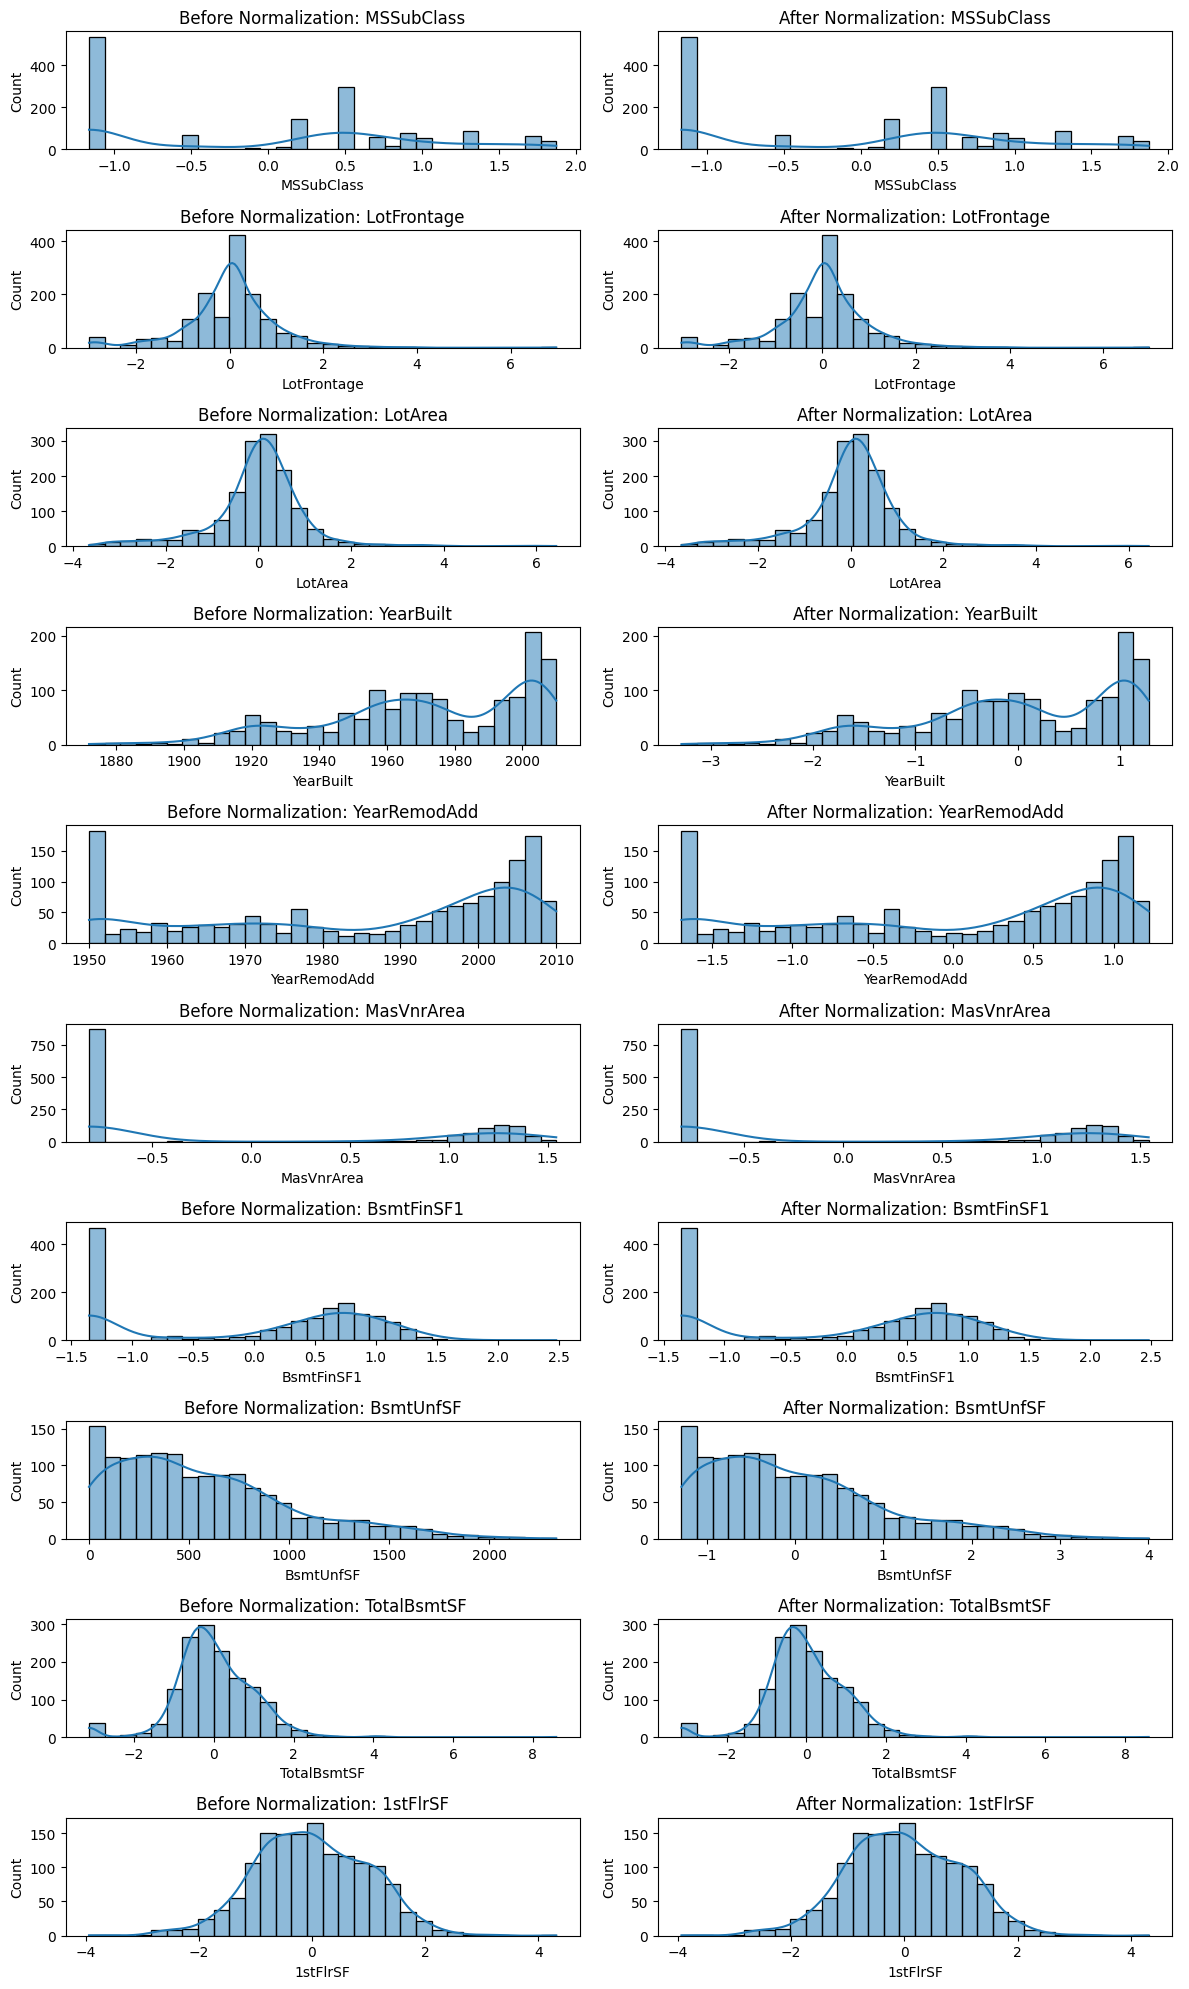

In [75]:
scaler = StandardScaler()
train_df_scaled = train_df.copy()
train_df_scaled[continuous_features] = scaler.fit_transform(train_df[continuous_features])
print(train_df_scaled[continuous_features].head())
# Select a few continuous features to visualize
sample_features = continuous_features[:10] 

# --- Histograms Before vs After Normalization ---
fig, axes = plt.subplots(len(sample_features), 2, figsize=(12, 20))

for i, col in enumerate(sample_features):
    # Before normalization
    sns.histplot(train_df[col], ax=axes[i, 0], kde=True, bins=30)
    axes[i, 0].set_title(f"Before Normalization: {col}")

    # After normalization
    sns.histplot(train_df_scaled[col], ax=axes[i, 1], kde=True, bins=30)
    axes[i, 1].set_title(f"After Normalization: {col}")

plt.tight_layout()
plt.show()

In [76]:
train_df[continuous_features].skew()

MSSubClass      0.069019
LotFrontage     0.167283
LotArea         0.026569
YearBuilt      -0.613461
YearRemodAdd   -0.503562
MasVnrArea      0.426258
BsmtFinSF1     -0.411401
BsmtUnfSF       0.920268
TotalBsmtSF     0.232534
1stFlrSF       -0.001106
2ndFlrSF        0.813030
GrLivArea       0.000171
TotRmsAbvGrd    0.676341
GarageArea      0.179981
WoodDeckSF      0.132275
OpenPorchSF    -0.014772
MoSold          0.212053
SalePrice      -0.008654
dtype: float64

In [77]:
backup_df = train_df.copy(deep=True)

In [78]:
train_df = backup_df.copy(deep=True) # run this to undo all the transformations.

In [79]:
train_df.dtypes

Id                          int64
MSSubClass                float64
LotFrontage               float64
LotArea                   float64
LandSlope                 float64
OverallQual                 int64
OverallCond                 int64
YearBuilt                   int64
YearRemodAdd                int64
MasVnrArea                float64
ExterQual                   int64
ExterCond                   int64
BsmtQual                  float64
BsmtCond                  float64
BsmtExposure              float64
BsmtFinType1              float64
BsmtFinSF1                float64
BsmtFinType2              float64
BsmtUnfSF                   int64
TotalBsmtSF               float64
HeatingQC                   int64
1stFlrSF                  float64
2ndFlrSF                    int64
GrLivArea                 float64
BsmtFullBath                int64
FullBath                    int64
HalfBath                    int64
BedroomAbvGr                int64
KitchenQual                 int64
TotRmsAbvGrd  

In [80]:
mapping = {
    "Pre1940": 0,
    "1940-1970": 1,
    "1970-1990": 2,
    "1990-2000": 3,
    "Post2000": 4,
    "NoGarage": -1 
}

train_df["GarageYrBlt_Binned"] = train_df["GarageYrBlt_Binned"].map(mapping).astype(int)

In [81]:
train_df['GarageYrBlt_Binned']

0       4
1       2
2       4
3       3
4       3
5       3
6       4
7       2
8       0
9       0
10      1
11      4
12      1
13      4
14      1
15      3
16      1
17      1
18      4
19      1
20      4
21      0
22      4
23      2
24      1
25      4
26      4
27      4
28      1
29      0
30      0
31      1
32      4
33      1
34      4
35      4
36      3
37      1
38      1
39     -1
40      1
41      1
42      2
43      2
44      1
45      4
46      4
47      4
48     -1
49      1
50      3
51      2
52      1
53      2
54      1
55      1
56      3
57      4
58      4
59      2
60      4
61      0
62      4
63      2
64      3
65      4
66      1
67      4
68      1
69      1
70      2
71      2
72      3
73      2
74      0
75      2
76      1
77      1
78     -1
79      1
80      1
81      3
82      4
83      2
84      3
85      3
86      4
87      4
88     -1
89     -1
90      1
91      1
92      0
93      0
94      3
95      3
96      3
97      1
98      0
99     -1


/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)
/usr/local/lib/python3.10/dist-packages/seaborn/matrix.py:560: UserWarning: Clustering large matrix with scipy. Installing `fastcluster` may give better performance.
  warnings.warn(msg)


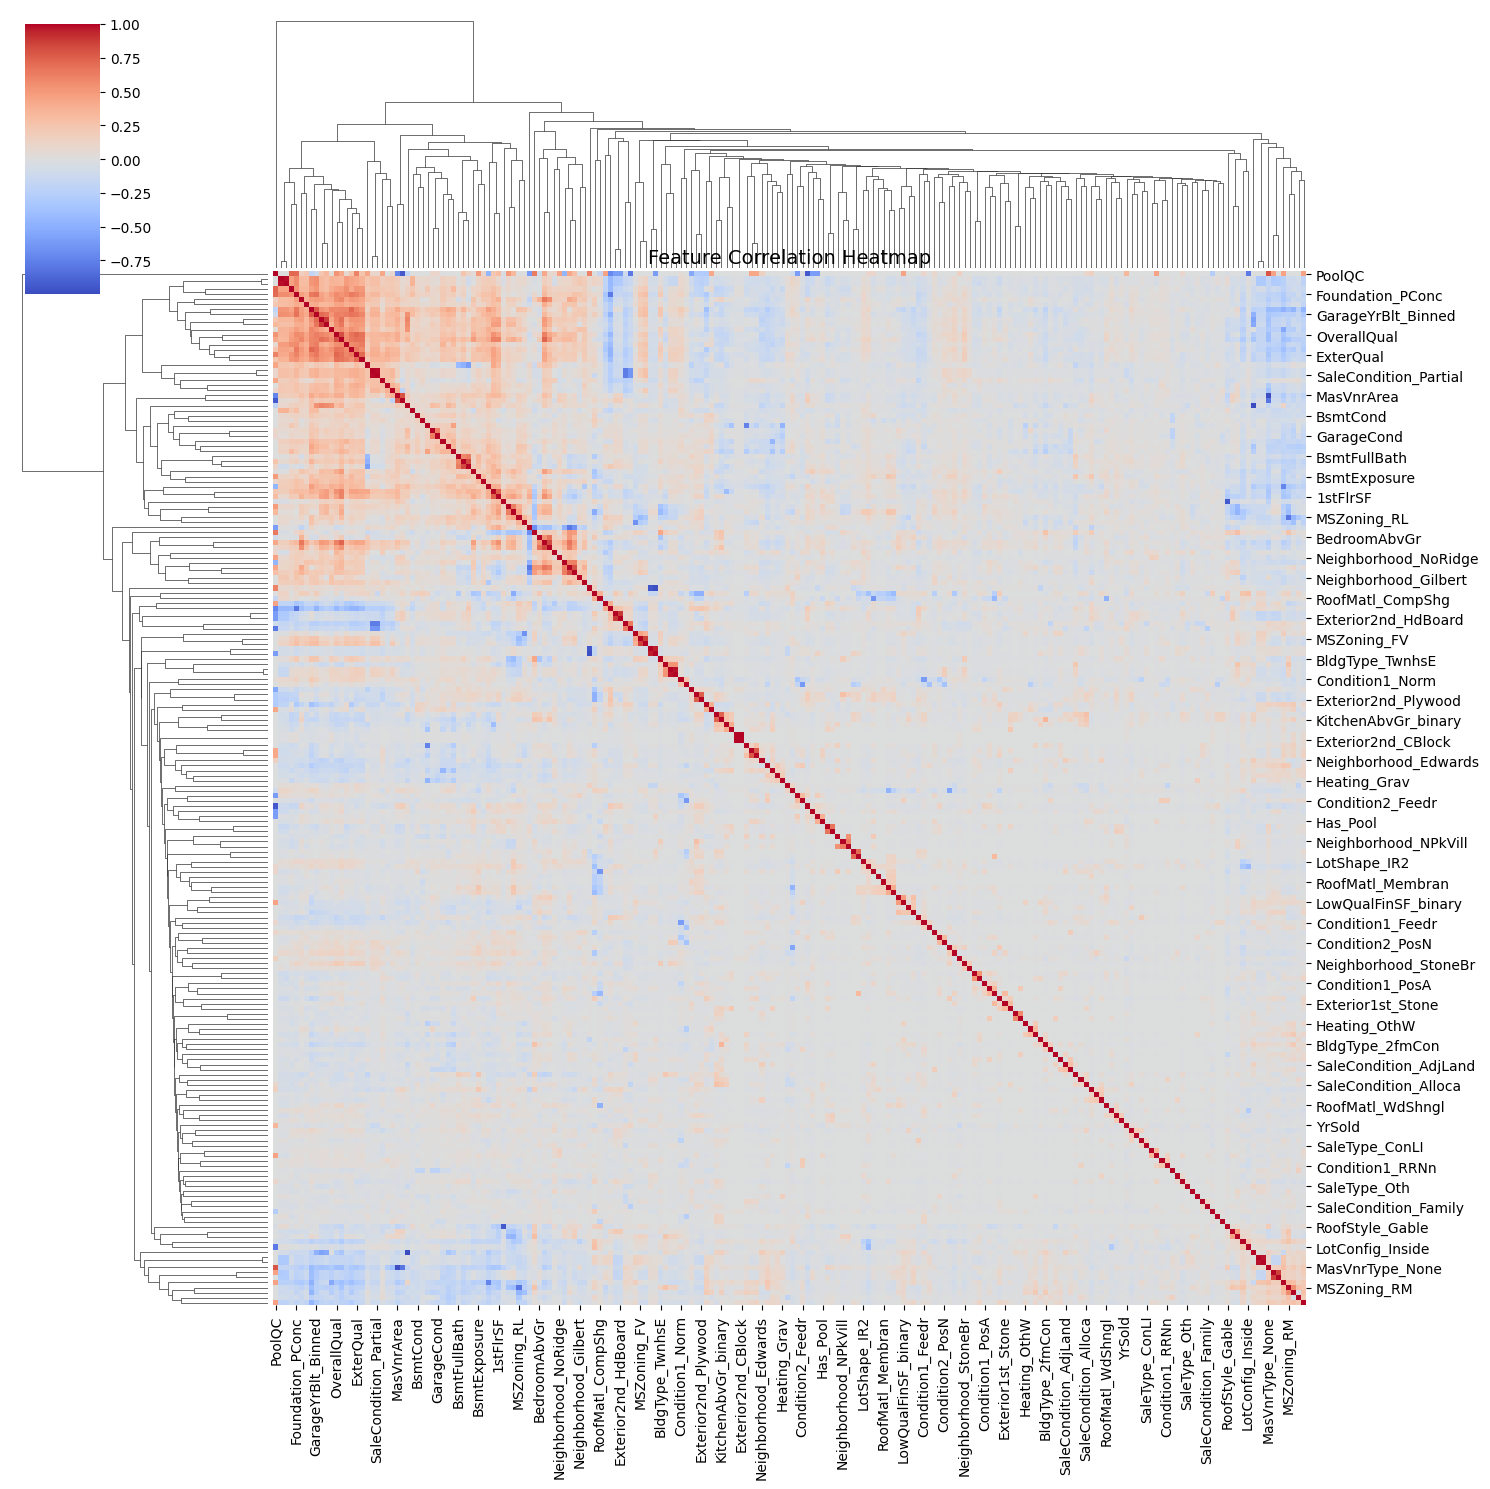

In [82]:
corr_matrix = train_df.corr()

corr_matrix = corr_matrix.replace([np.inf, -np.inf], np.nan)  # Replace infinities with NaN
corr_matrix = corr_matrix.fillna(0)  # Fill NaNs with 0 (or use corr_matrix.dropna())
g = sns.clustermap(corr_matrix, cmap='coolwarm', figsize=(15, 15))

g.ax_heatmap.set_title("Feature Correlation Heatmap", fontsize=14)

plt.show()

In [83]:
threshold = 0.8
corr_matrix = train_df.corr()
highly_correlated_features = np.where(np.abs(corr_matrix) > threshold)

correlated_pairs = [
    (corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j])
    for i, j in zip(*highly_correlated_features) if i != j
]

# Remove duplicate pairs (since correlation matrix is symmetric)
correlated_pairs = list(set(tuple(sorted(pair[:2])) + (pair[2],) for pair in correlated_pairs))

correlated_pairs.sort(key=lambda x: abs(x[2]), reverse=True)

for feature1, feature2, corr_value in correlated_pairs:
    print(f"{feature1} - {feature2}: {corr_value:.2f}")

Exterior1st_CBlock - Exterior2nd_CBlock: 1.00
GarageType_None - GarageYrBlt: -1.00
SaleCondition_Partial - SaleType_New: 0.99
MasVnrArea - MasVnrType_None: -0.99
MiscFeature_None - MiscVal_binary: -0.98
Exterior1st_VinylSd - Exterior2nd_VinylSd: 0.98
Exterior1st_CemntBd - Exterior2nd_CmentBd: 0.97
Exterior1st_MetalSd - Exterior2nd_MetalSd: 0.97
MiscFeature_None - MiscFeature_Shed: -0.95
MiscFeature_Shed - MiscVal_binary: 0.95
Neighborhood_NWAmes - PoolQC: -0.93
MasVnrType_BrkFace - PoolQC: -0.93
RoofStyle_Gable - RoofStyle_Hip: -0.93
Exterior1st_HdBoard - Exterior2nd_HdBoard: 0.88
GarageArea - GarageCars: 0.88
MSZoning_FV - Neighborhood_Somerst: 0.86
Exterior1st_Wd Sdng - Exterior2nd_Wd Sdng: 0.86
BsmtFinSF1 - BsmtFinType1: 0.83
GrLivArea - TotRmsAbvGrd: 0.83
OverallQual - SalePrice: 0.82
2ndFlrSF - HouseStyle_2Story: 0.81
MSZoning_RL - MSZoning_RM: -0.81
MasVnrType_BrkFace - MasVnrType_None: -0.81


/usr/local/lib/python3.10/dist-packages/pandas/core/computation/expressions.py:73: RuntimeWarning: invalid value encountered in greater
  return op(a, b)
